In [1]:
'''Import .nc for TOPAZ with and without assimilation
Substract SIT (with - without)
Extract PCA on test period (2014-2022)
Save PCA as.pkl file and SIT values as .nc, both over test period
'''

import xarray as xr
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import yaml
import pickle as pkl
from datetime import datetime
from datetime import timedelta
from glob import glob

from src.data_preparation import load_data
from src.data_preparation import mdl_dataset_prep
from src.feature_extraction import extract_pca
from src.visualization import visualize_pca
from src.utils import load_config
from src.utils import tardisml_utils


rootdir = tardisml_utils.get_rootdir()

# ----------------------
#       Parameters
# ----------------------

years = [2011, 2022]
adjSIC = False  ## to use SIT adjusted with SIC >15%


# Path to config file
file_config = '../config/config_default_2023.yaml'
# file_config = '../config/config_default_2023_bias_N20.yaml'


file_template = '../config/template_name.yaml'

template = yaml.load(open(file_template),Loader=yaml.FullLoader)
load_config.update_config(file_config, verbose=True)
nosit_dir, withsit_dir, _, forcing_bdir, pca_dir, res_dir, fig_dir, ml_dir, _ = load_config.load_filename(file_config)
timeofday, target_field, forcing_fields, covar_fields, lim_idm, lim_jdm, n_comp = load_config.load_config_params(file_config)


# ------------  Import TOPAZ ------------

data_kind = "withsit"
n_components = load_config.get_n_components(data_kind, file_config)

print('Loading TOPAZ datasets...')

suffix = '_FreeRun'  # without assimilation
if adjSIC:
    suffix += '_adjSIC'
filename = os.path.join(rootdir, pca_dir, f"{target_field}_TOPAZ4b23_{years[0]}_{years[-1]}{suffix}.nc")
X_na, chrono_na = load_data.load_nc(filename, f'{target_field}', True)

# with assimilation
filename = os.path.join(rootdir, pca_dir, f"{target_field}_TOPAZ4b23_{years[0]}_{years[-1]}.nc")
if adjSIC:
    filename = os.path.join(rootdir, pca_dir, f"{target_field}_TOPAZ4b23_{years[0]}_{years[-1]}_adjSIC.nc")
    
X_a, chrono_a = load_data.load_nc(filename, f'{target_field}', True)


# ------------  Compute bias ------------
nc_sel_e = X_a - X_na

# Both TOPAZ versions should span from 2011-2022. Just a check to keep only common times
chrono_e = chrono_na.merge(chrono_a)

# split dataset train/eval/test
ntrain, nval, ntest = mdl_dataset_prep.dataset_split_3yrs(nc_sel_e.shape[0], train_p=1, val_p=0)
# nc_sel_e = nc_sel_e[ntest+nval:]  # only training dataset ntrain
# chrono_e = chrono_e[ntest+nval:]
suffix = ''
if adjSIC:
    suffix += '_adjSIC'

first_year = chrono_e.iloc[0].date.year  # 2014
last_year = chrono_e.iloc[-1].date.year  # 2022

# ------------ Compute PCA for 2011-2022 ------------
ofile_pca = '' # os.path.join(rootdir, pca_dir, f'pca_{target_field}_{n_components}N_SITerr23_{first_year}_{last_year}{suffix}.pkl')
ofile_X = ''

mu_e, X_e, X1d_nonan, pca_e, maskok = extract_pca.compute_pca_TOPAZ(nc_sel_e, n_components, lim_idm, lim_jdm, ofile_pca, ofile_X)

# Compute EOF
EOF1d, EOF2d_e = extract_pca.compute_eof(n_components, X_e, pca_e, maskok)
PCs_e = xr.DataArray(pca_e.transform(X1d_nonan), dims=['time','comp'])
print('Variance 2011-22: ', pca_e.explained_variance_ratio_.cumsum())

# ------------- Compute PCA for 2014-2022

nc_sel_e = nc_sel_e[ntest+nval:]  # only training dataset ntrain
chrono_e = chrono_e[ntest+nval:]
suffix = ''
if adjSIC:
    suffix += '_adjSIC'

first_year = chrono_e.iloc[0].date.year  # 2014
last_year = chrono_e.iloc[-1].date.year  # 2022

ofile_pca = '' # os.path.join(rootdir, pca_dir, f'pca_{target_field}_{n_components}N_SITerr23_{first_year}_{last_year}{suffix}.pkl')
ofile_X = ''

mu_e, X_e, X1d_nonan, pca_e, maskok = extract_pca.compute_pca_TOPAZ(nc_sel_e, n_components, lim_idm, lim_jdm, ofile_pca, ofile_X)

# Compute EOF
EOF1d, EOF2d_e14 = extract_pca.compute_eof(n_components, X_e, pca_e, maskok)
PCs_e14 = xr.DataArray(pca_e.transform(X1d_nonan), dims=['time','comp'])


print('Variance 2014-22: ', pca_e.explained_variance_ratio_.cumsum())

PCA results in: /scratch/project_465000269/edelleo1/Leo/results/pca_i100-550_j150-629
Config file updated (pca_dir): ../config/config_default_2023.yaml
Config file updated: ../config/config_default_2023.yaml
Results in: /scratch/project_465000269/edelleo1/Leo/results/lstm_Npred0_7F_rw29d_N8844_H1333_Hn0000_sithick_noname_231130-113359
Folder created

Config file updated.
Loading TOPAZ datasets...
Compute ocean/land mask...
Compute PCA with ncomp = 8...
Variance 2011-22:  [0.1360602  0.22847344 0.301575   0.36413962 0.4182028  0.45123002
 0.48118293 0.50798976]
Compute ocean/land mask...
Compute PCA with ncomp = 8...
Variance 2014-22:  [0.14846267 0.24832037 0.32885286 0.3910293  0.45148504 0.48920575
 0.5220184  0.54842824]


In [2]:
import copy
from sklearn.preprocessing import MinMaxScaler

# new Scale

In [42]:
def scale_wreshape(X):
    dim0, dim1 = X.shape[0], X.shape[1]
    
    idx_nonan_1d = np.where(~np.isnan(X.to_numpy().reshape((dim0*dim1))))
    idx0 = np.where((X.to_numpy().reshape((dim0*dim1))==0))[0]
    ascolumns = X.to_numpy().reshape(-1, dim0*dim1)
    ascol_nonan = ascolumns[0, idx_nonan_1d]
    scaler = MinMaxScaler(feature_range=(-1,1))
    t = scaler.fit_transform(ascol_nonan.reshape((-1,1)))
    t_wnan = copy.deepcopy(ascolumns)
    t_wnan[0, idx_nonan_1d] = t[:,0]
    # import pdb;pdb.set_trace()
    
    t_wnan[0, idx0] = 0
    transformed = t_wnan.reshape(dim0,dim1)
    return transformed

In [ ]:
# ----------------- Compare PCA 2011-2022 and 2014-2022 ------------------

In [43]:
eof14_s = copy.deepcopy(EOF2d_e14)
eof11_s = copy.deepcopy(EOF2d_e)

for n in range(EOF2d_e14.shape[0]):
    eof14_s[n] = scale_wreshape(EOF2d_e14[n])    
    eof11_s[n] = scale_wreshape(EOF2d_e[n])

In [45]:
EOF_diff = eof11_s - eof14_s

# For PC scaling

## todo: scale time coefficient for each component and also do difference

In [78]:
PC_diff = PCs_e[ntest:] - PCs_e14

In [80]:
PCs_e.shape

(4383, 8)

In [87]:
def scale_1D(X):
    
    scaler = MinMaxScaler(feature_range=(-1,1))
    t = scaler.fit_transform(X.to_numpy().reshape((-1,1)))
    
    return t[:,0]

In [90]:
PC14_s = copy.deepcopy(PCs_e14)
PC11_s = copy.deepcopy(PCs_e[ntest:])

for n in range(PC14_s.shape[1]):
    PC14_s[:, n] = scale_1D(PCs_e14[:, n])    
    PC11_s[:, n] = scale_1D(PCs_e[ntest:, n])

In [93]:
PC_diff_scaled = PC11_s - PC14_s

In [97]:
PC_diff_scaled

<xarray.DataArray (time: 3287, comp: 8)>
array([[ 0.01654202,  0.05155686, -0.13492826, ..., -0.0020754 ,
        -0.07592002,  0.5160911 ],
       [ 0.01568764,  0.05123249, -0.13604063, ..., -0.00099596,
        -0.07625636,  0.5231589 ],
       [ 0.01484072,  0.050771  , -0.13716304, ...,  0.00105366,
        -0.07778393,  0.5303499 ],
       ...,
       [ 0.00915194,  0.00560975,  0.05539199, ...,  0.08364218,
         0.089394  ,  0.5209267 ],
       [ 0.00972474,  0.00699759,  0.05256913, ...,  0.08440818,
         0.08311801,  0.5307529 ],
       [ 0.00984675,  0.00797319,  0.04996048, ...,  0.08566051,
         0.07690013,  0.54005444]], dtype=float32)
Dimensions without coordinates: time, comp

# Plot

In [14]:
from src.utils import modif_plot

In [117]:
def plot_save_eof_diff(chrono, EOF2d, PC_diff, max_plot=8, n_components=8, ofile='', savefig=False, showfig=True):
    """ Plot EOF and PC and save it in the given filename.
    In:
        chrono       : pandas.core.series.Series
        max_plot     : int
        n_components : int
        EOF2d        : xarray.core.dataarray.DataArray
        PCs_f        : xarray.core.dataarray.DataArray
        filename     : String  -- name in which to save the file (don't save if empty)    
    """
    
    if n_components < max_plot:
        max_plot = n_components
    
    mini = -2
    maxi = 2
    
    my_cmap = plt.get_cmap('bwr')
    
    fig, axes = plt.subplots(ncols=2, nrows=max_plot, figsize=(12,max_plot*3), constrained_layout=True)
    
    for i in range(max_plot):
        im = axes[i, 0].imshow(EOF2d.isel(comp=i),origin='lower', vmin=mini, vmax=maxi, cmap=my_cmap)

        plt.colorbar(im, ax=axes[i, 0]) #,   format='%.0e')
        axes[i, 0].set_ylabel(f'EOF #{i+1}')
        
        axes[i, 1].plot(chrono, PC_diff[:,i])
        axes[i, 1].set_ylim([-2,2])
        
        # decoration
        axes[i,0].set_facecolor('grey')
        axes[i,0].tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)     
    
        # annotate the 95 percentile of absolute values (removing values=0)
        perc95 = np.nanpercentile(abs(EOF2d.isel(comp=i).where(EOF2d.isel(comp=i)!=0)).to_numpy(), 95)
        axes[i,0].annotate(f'{perc95:.02f}', xy=(.95,.85), xycoords='axes fraction', color='w', ha='right', fontsize=24)
    
        # annotate the 95 percentile of absolute values (removing values=0)
        perc95 = np.nanpercentile(abs(PC_diff.isel(comp=i)).to_numpy(), 95)
        axes[i,1].annotate(f'{perc95:.02f}', xy=(.95,.90), xycoords='axes fraction', color='k', ha='right', fontsize=24)
        axes[i,1].spines[['right', 'top']].set_visible(False)
        axes[i,1].axhline(0, c='grey', ls='--', zorder=-5)

    
    axes[0,0].set_title('EOF')
    axes[0,1].set_title('PC');
    
    modif_plot.resize(fig, s=14, rx=-25)
    
    if savefig:
        plt.savefig(ofile, bbox_inches='tight')
        print(f'Saved as: {ofile}')
        
    if showfig:
        plt.show()
        
    plt.close()

Saved as: la_PCA8_SITerr23_EOF_PC_2011-22_2014-22_scaled_01.png


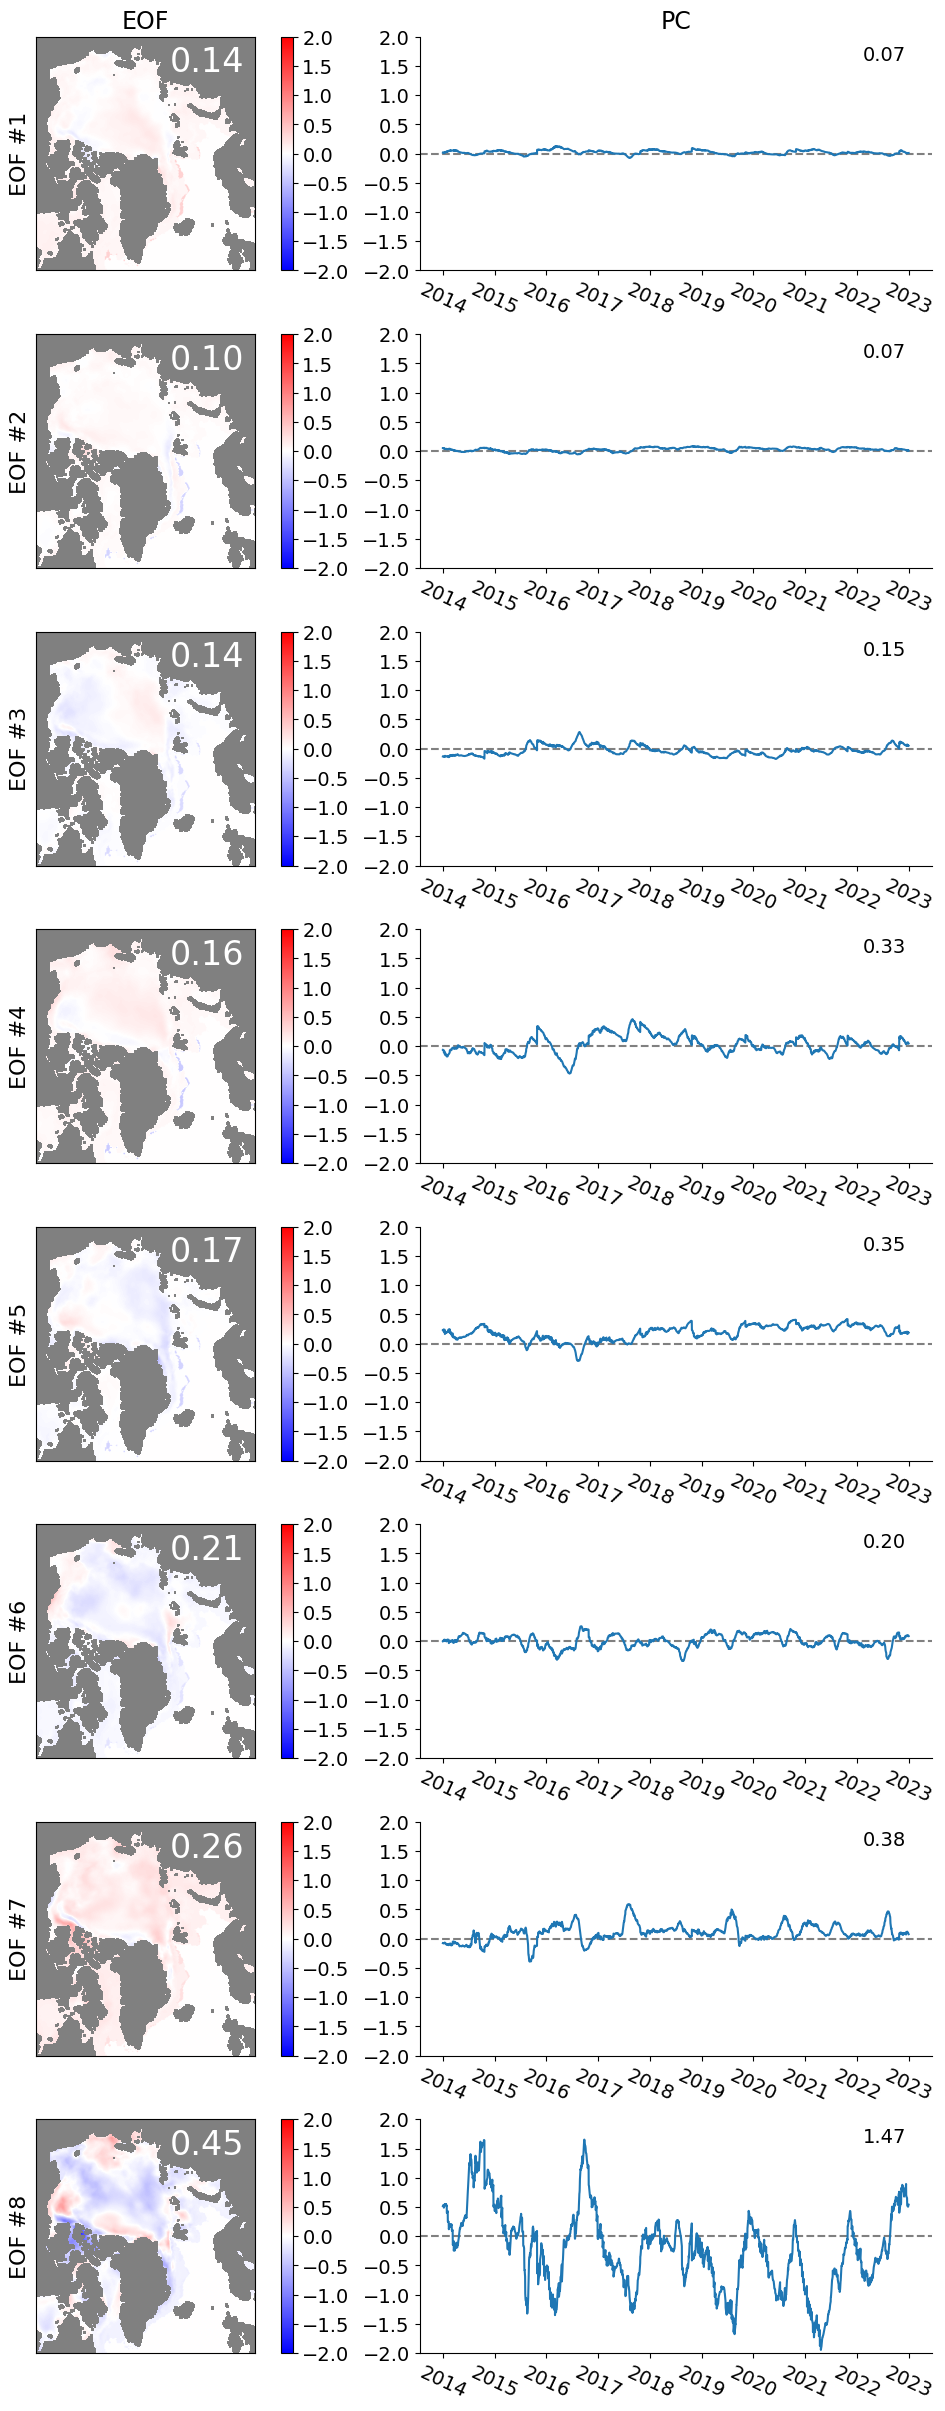

In [118]:
filename = f'la_PCA{n_components}_SITerr23_EOF_PC_2011-22_2014-22_scaled_01.png'
plot_save_eof_diff(chrono_e, EOF_diff, PC_diff_scaled, showfig=True, savefig=True, ofile=filename)

In [ ]:



EOF_diff = EOF2d_e - EOF2d_e14


# Scale to observe the difference better ? and coefficient are relative to decomposition anyway ?
# from src.data_preparation import scaling
# EOF11_s = scaling.scale_3D(EOF2d_e)

In [ ]:
PCs_diff = PCs_e[ntest+nval:] - PCs_e14

In [ ]:
# ------------ PLOT ------------

filename = f'{rootdir}{fig_dir}{target_field}_PCA{n_components}_SITerr23_EOF_PC_2011-22_2014-22{suffix}_scaled.png'
visualize_pca.plot_save_eof(chrono_e, n_components, n_components, EOF_diff, PCs_diff, target_field, 0, ofile=filename)


# Visualize cumulative explained variance of the first axes
# filename = f'{rootdir}{fig_dir}{target_field}_PCA{n_components}_Xe23_cumvar_{years[0]}_{years[-1]}{suffix}.png'
# visualize_pca.plot_pca_variance(n_components, pca_e, target_field, True, filename)

filename = f'{rootdir}{fig_dir}{target_field}_PCA{n_components}_SITerr23_EOF_PC_2011-22_scaled.png'
visualize_pca.plot_save_eof(chrono_e, n_components, n_components, EOF11_s, PCs_diff, target_field, 0, ofile=filename)



filename = f'{rootdir}{fig_dir}{target_field}_PCA{n_components}_SITerr23_EOF_PC_2014-22{suffix}.png'
visualize_pca.plot_save_eof(chrono_e, n_components, n_components, EOF2d_e14, PCs_e14, target_field, 0, ofile=filename)

# Draft Scaling

In [149]:
ascolumns = EOF2d_e14[0].to_numpy().reshape(-1, 479*450)

In [150]:
idx_nonan_1d.shape

(215550,)

In [151]:
ascolumns.shape

(1, 215550)

In [152]:
ascol_nonan = ascolumns[0, idx_nonan_1d]

In [153]:
ascol_nonan.shape

(118882,)

In [154]:
scalers[1] = MinMaxScaler(feature_range=(-1,1,))

In [155]:
t = scalers[1].fit_transform(ascol_nonan.reshape((-1,1)))

(array([3.7200e+02, 1.0390e+03, 1.9780e+03, 9.3250e+03, 1.4380e+04,
        1.7395e+04, 7.2430e+04, 1.8850e+03, 6.9000e+01, 9.0000e+00]),
 array([-0.01409051, -0.01187822, -0.00966592, -0.00745362, -0.00524132,
        -0.00302902, -0.00081672,  0.00139557,  0.00360787,  0.00582017,
         0.00803247]),
 <BarContainer object of 10 artists>)

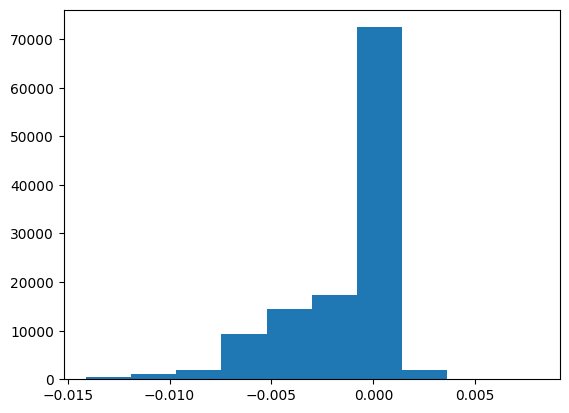

In [156]:
plt.hist(ascol_nonan)

In [157]:
t.shape

(118882, 1)

In [158]:
#ascolumns[0, idx_nonan_1d] = t[:,0]

In [159]:
t_wnan = copy.deepcopy(ascolumns)

In [160]:
t_wnan[0, idx_nonan_1d] = t[:,0]

In [161]:
t_wnan.shape

(1, 215550)

In [162]:
transformed = t_wnan.reshape(479,450)

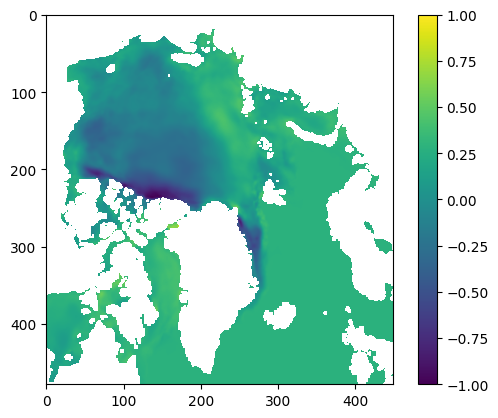

In [163]:
plt.imshow(transformed[::-1])
plt.colorbar()